In [1]:
from importlib import reload

import DataProvider
import Betas

reload(DataProvider)
reload(Betas)

<module 'Betas' from '/home/vincent/vincent/sharedwork/data/market-hedging/Betas.py'>

# Compute betas

In [14]:
%time

start_date = "2013-10-01"
end_date = "2018-10-01"

n_stocks = 10
ref_name = "SPY"

# We take a random set of stocks
# TODO Ensure there's a certain proportion of small/medium/large stocks
data = DataProvider.get_random_securities(n_stocks, start_date, end_date)
data_ref = DataProvider.get_securities(ref_name, start_date, end_date)

In [15]:
data.groupby("symbol").describe()

,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
AACC,955.0,5.403785,1.162873,2.860000,4.500000,5.570000,6.490000,7.970000
CHDX,1199.0,14.255096,4.353035,7.760000,10.535000,13.440000,16.910000,23.990000
CLRO,2221.0,7.230131,3.059483,1.570000,3.972178,7.714492,9.798962,13.372140
GAS,1636.0,41.117857,11.011886,26.301714,32.533089,36.972763,48.335807,66.010000
LVNTB,1400.0,37.548752,11.960867,11.281693,32.029486,38.908452,42.267500,66.440543
MOCO,1888.0,13.899882,3.694143,7.274009,12.467499,13.417163,14.950984,30.050000
PMFG,1428.0,10.902295,5.560836,4.130000,6.327500,7.970000,16.062500,27.300000
POOL,2221.0,65.225830,39.954785,16.013478,33.088038,54.130122,92.334294,174.690000
SSB,2221.0,55.198688,22.106996,21.542800,31.640339,56.832448,73.410825,92.462664


In [3]:
df = Betas.attach_return(data, "symbol")
df_ref = Betas.attach_return(data_ref, "symbol")

df0 = df.reset_index().merge(
    df_ref.reset_index().drop("symbol", axis=1),
    on="date",
    suffixes=["", "_ref"]
).dropna().set_index(df.index.names)

In [4]:
%time
df = Betas.attach_beta(df0, "return_ref", "return", "symbol", 15, numpy=False)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


In [5]:
%time
df = Betas.attach_beta(df0, "return_ref", "return", "symbol", 15, numpy=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [6]:
df.head(10)

,,adjClose,return,adjClose_ref,return_ref,beta
symbol,date,,,,,
BJRI,2010-01-05,18.775459,0.011200,95.339988,0.002647,0.000030
SSRI,2010-01-05,23.360000,0.026362,95.339988,0.002647,0.000070
KOF,2010-01-05,54.731673,-0.015749,95.339988,0.002647,-0.000042
PLPC,2010-01-05,38.591556,0.000000,95.339988,0.002647,-0.000000
MRTN,2010-01-05,6.485652,-0.014045,95.339988,0.002647,-0.000037
JBN,2010-01-05,8.320758,-0.003036,95.339988,0.002647,-0.000008
JHG,2010-01-05,28.765792,0.032538,95.339988,0.002647,0.000086
PXD,2010-01-05,50.618487,0.000392,95.339988,0.002647,0.000001
BJRI,2010-01-06,18.765556,-0.000527,95.407111,0.000704,6.035429


For faster implementation, here are some alternative:

* Each regression can be computed in parallel. Dask is a library that implements numpy/pandas in parallel.
* Each security can be computed in parallel, and the least square solution for each security can be found by gradient descent using an exponentially decaying momentum in the gradient, by going through the points in a chronological order. This has the advantage that the data only has to be read once, and does not need to be loaded completely in memory, but this may affect the betas obtained.

Further development:

* Integrated code tests
* Validate and sanitize input
* Handle missing values
* Clean outliers
* Include standard errors on betas
* Non-parametric estimation of betas

# Analyse betas

In [7]:
df.groupby("symbol")["beta"].describe()

,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
BJRI,2220.0,0.948901,0.909650,-5.097867,0.527510,0.944978,1.357888,8.435321
IHTA,228.0,0.127236,0.592359,-1.519165,-0.059345,0.070152,0.374180,5.777805
JBN,2218.0,0.064836,1.046268,-6.642160,-0.173630,0.132391,0.468675,10.211698
JHG,2220.0,1.765099,0.929441,-8.592667,1.329833,1.773036,2.200450,14.943442
KOF,2220.0,0.903603,0.647903,-9.830619,0.577526,0.875155,1.222116,5.988005
LOB,823.0,1.037901,0.850299,-3.780962,0.552562,0.984093,1.505786,4.296377
MRTN,2220.0,1.240017,0.871453,-1.798046,0.752717,1.154748,1.610552,15.251647
PLPC,2220.0,1.168174,1.121463,-7.570449,0.510421,1.070466,1.720362,6.497879
PXD,2220.0,1.508413,0.957330,-8.779113,1.002061,1.487450,1.941601,7.516195


There are suspicious outliers, when looking at the 25/75 percentile vs min/max.

In [8]:
p = df.reset_index("symbol").groupby("symbol")["beta"].plot()

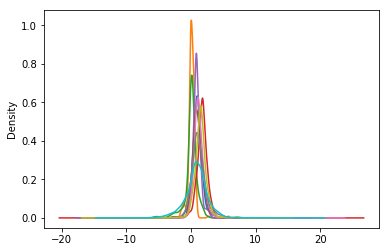

In [9]:
p = df.reset_index("symbol").groupby("symbol")["beta"].plot(kind="density")

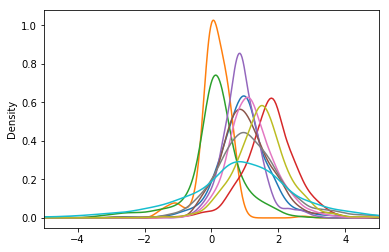

In [11]:
threshold = 5
p = df.reset_index("symbol").groupby("symbol")["beta"].plot(kind="density", xlim=(-threshold, threshold))